# 1. Getting the Data

We will be scrapping data from the web: https://www.airlinequality.com/

In [20]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import string
import nltk
from nltk.corpus import stopwords

In [2]:
base_url = 'https://www.airlinequality.com/airline-reviews/british-airways'
pages = 10
page_size = 120

reviews = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 120 total reviews
Scraping page 2
   ---> 240 total reviews
Scraping page 3
   ---> 360 total reviews
Scraping page 4
   ---> 480 total reviews
Scraping page 5
   ---> 600 total reviews
Scraping page 6
   ---> 720 total reviews
Scraping page 7
   ---> 840 total reviews
Scraping page 8
   ---> 960 total reviews
Scraping page 9
   ---> 1080 total reviews
Scraping page 10
   ---> 1200 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | My husband and myself were ...
1,✅ Trip Verified | Organised boarding process. ...
2,✅ Trip Verified | Outward journey BA245 Londo...
3,✅ Trip Verified | Check in agent at LHR was ve...
4,✅ Trip Verified | Very disappointing. I book ...


In [4]:
df.to_csv("BA_reviews.csv")

In [2]:
df = pd.read_csv('BA_reviews.csv',index_col=0)

In [3]:
df['reviews'].apply(lambda x: x.split('|')[0])

0         ✅ Trip Verified 
1         ✅ Trip Verified 
2         ✅ Trip Verified 
3         ✅ Trip Verified 
4         ✅ Trip Verified 
               ...        
1195    ✅ Verified Review 
1196    ✅ Verified Review 
1197    ✅ Verified Review 
1198    ✅ Verified Review 
1199    ✅ Verified Review 
Name: reviews, Length: 1200, dtype: object

In [6]:
df.columns

Index(['reviews'], dtype='object')

In [4]:
df['reviews'] = df['reviews'].str.replace('✅ Trip Verified ', '')

In [5]:
df['reviews'] = df['reviews'].str.replace('✅ Verified Review ', '')

In [6]:
df['reviews'] = df['reviews'].str.replace(r'|', '')

C:\Users\katya\AppData\Local\Temp\ipykernel_8772\1202216375.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['reviews'] = df['reviews'].str.replace(r'|', '')


In [7]:
df

,reviews
0,My husband and myself were flying to Madrid ...
1,Organised boarding process. Really friendly c...
2,Outward journey BA245 London to Buenos Aires...
3,Check in agent at LHR was very helpful and fr...
4,Very disappointing. I book BA so I can fly d...
...,...
1195,Las Vegas to London Heathrow. This particula...
1196,London City to Edinburgh. Flight left on-tim...
1197,Faro to Gatwick. Check in was quiet at the c...
1198,Los Angeles to London Heathrow. The inflight...


## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

A new column to detect how long the text messages are:

In [8]:
df['length'] = df['reviews'].apply(len)

In [9]:
df.head()

,reviews,length
0,My husband and myself were flying to Madrid ...,1579
1,Organised boarding process. Really friendly c...,160
2,Outward journey BA245 London to Buenos Aires...,1775
3,Check in agent at LHR was very helpful and fr...,415
4,Very disappointing. I book BA so I can fly d...,534


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

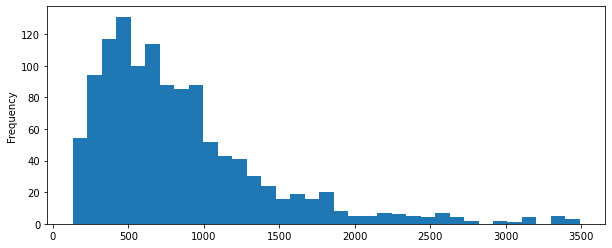

In [64]:
plt.figure(figsize=(10,4))
df['length'].plot.hist(bins=35)
plt.savefig('length_hist.png')

Let's try to explain why the x-axis goes all the way to 3500ish, this must mean that there is some really long message!

In [12]:
df.length.describe()

count    1200.000000
mean      841.601667
std       569.586365
min       131.000000
25%       442.000000
50%       703.000000
75%      1049.250000
max      3491.000000
Name: length, dtype: float64

Woah! 3491 characters, let's use masking to find this review:

In [13]:
df[df['length']==3491]['reviews'].iloc[0]

'  Toronto to LHR and LGW to Toronto return in WT+. Finally, BA has moved back into it’s own lounge which has been refurbished with new furniture. However, Premium Plaza still staff and operate the lounge. Food was ok – but the drinks choices remain poor. Slick boarding and a full PE cabin on a 777. Water and juice offered on boarding but still no prosecco offered on flights TO London. (apparently 3 are loaded in London for the O/W leg but none for the return.) Friendly mixed fleet crew who offered good service. Fast bar service followed by Veggie pasta or chicken stir fry offered which was foul. salty, dry and overcooked with reheated rice and mushy vegetables. The salad is a nonsense – a few leaves and a tomato slice. Pudding was sickly chocolate sponge thing which was gross. Got a couple of hours sleep. However the IFE froze after take off due to the PA system remaining locked on and preventing the IFE from working. A reset halfway through the flight worked, though two loud renditio

Looks like someone is happy with the great boarding experience and on-time performance that BA has to offer!! Anyways let's focus back on our Analysis

# Tokenization 

In [14]:
import string

In [15]:
def text_process(review):
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in review if char not in string.punctuation]
    
    # Join the characters again to form the string
    nopunc = ''.join(nopunc)
    return nopunc
    

In [16]:
nopunc = df['reviews'].apply(text_process)

In [17]:
nopunc

0         My husband and myself were flying to Madrid ...
1        Organised boarding process Really friendly cr...
2         Outward journey BA245 London to Buenos Aires...
3        Check in agent at LHR was very helpful and fr...
4         Very disappointing I book BA so I can fly du...
                              ...                        
1195      Las Vegas to London Heathrow This particular...
1196      London City to Edinburgh Flight left ontime ...
1197      Faro to Gatwick Check in was quiet at the cl...
1198      Los Angeles to London Heathrow The inflight ...
1199      Malaga to Gatwick Theyve introduced new cabi...
Name: reviews, Length: 1200, dtype: object

In [18]:
nopunc.shape[0]

1200

In [21]:
text = ''.join([word for word in nopunc if word not in stopwords.words('english')])

# VADER Sentiment Scoring

In [23]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [24]:
res = {}

for i in range(0, nopunc.shape[0]):
    res[i] = sia.polarity_scores(nopunc[i])




In [25]:
vaders = pd.DataFrame(res).T

In [26]:
vaders = vaders.join(df,how='left')

In [27]:
#Now we have sentiment score and metadeta
vaders.head()

,neg,neu,pos,compound,reviews,length
0,0.023,0.809,0.168,0.9933,My husband and myself were flying to Madrid ...,1579
1,0.000,0.605,0.395,0.9371,Organised boarding process. Really friendly c...,160
2,0.095,0.817,0.088,-0.0980,Outward journey BA245 London to Buenos Aires...,1775
3,0.203,0.578,0.219,0.3774,Check in agent at LHR was very helpful and fr...,415
4,0.093,0.854,0.054,-0.2374,Very disappointing. I book BA so I can fly d...,534


The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

# Plots

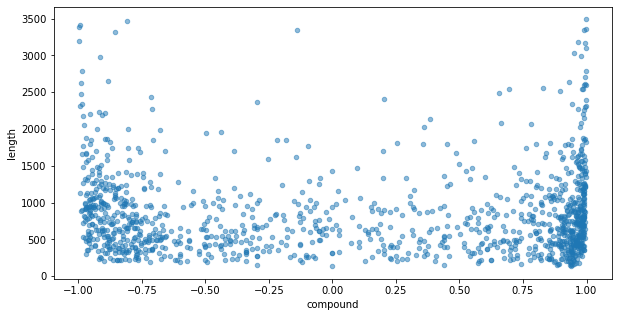

In [65]:
vaders.plot(kind='scatter',x='compound',y='length',figsize=(10,5),alpha=.5)
plt.savefig('scatter.png')

As clearly visible from the above plot there is no relationship between the Length and Sentiment of a review. A positive review can be short or long in length. Same goes for nuetral and negative reviews.

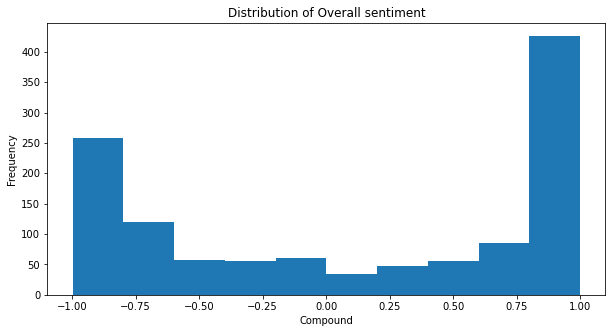

In [72]:
vaders['compound'].plot(kind='hist',figsize=(10,5))
plt.title('Distribution of Overall sentiment')
plt.xlabel('Compound')
plt.savefig('compund_hist.png')

We can see from the above plot, It's not all good news. We have mixed reviews. But on the bright side we have more positive reviews and have room for further imporvements. 

In [69]:
vaders[vaders['compound']>=0].shape[0]/vaders.shape[0]*100

54.50000000000001

54.5% - Positive Sentiment 

In [70]:
vaders[vaders['compound']<0].shape[0]/vaders.shape[0]*100

45.5

45.5% - Negative Sentiment

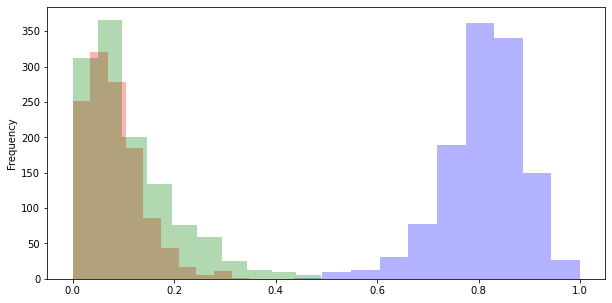

In [67]:
vaders['neg'].plot(kind='hist',figsize=(10,5),alpha=.3,color='red')
vaders['neu'].plot(kind='hist',figsize=(10,5),alpha=.3,color='blue')
vaders['pos'].plot(kind='hist',figsize=(10,5),alpha=.3,color='green')
plt.savefig('hist.png')

Distribution of Negative, Neutral and Positive reviews across the chosen sample.

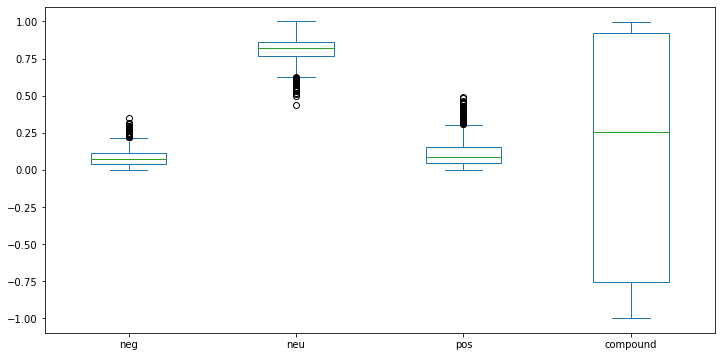

In [68]:
vaders[['neg', 'neu', 'pos', 'compound']].plot(kind='box',figsize=(12,6))
plt.savefig('box.png')

In [32]:
vaders.describe()['neu']

count    1200.000000
mean        0.810432
std         0.078463
min         0.436000
25%         0.769000
50%         0.818000
75%         0.864250
max         1.000000
Name: neu, dtype: float64

Mean and Max values of Nuetral reviews is dominant compared to other types of reviews which can be confirmed by multiple plots above.

# Generating WordCloud

In [33]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

In [34]:
from PIL import Image
from os import path, getcwd

In [35]:
d = getcwd()

In [47]:
mask_logo = np.array(Image.open(path.join(d,'BA.png')))

In [57]:
wc = WordCloud(background_color='white', max_words=1000, max_font_size=99, random_state=101, stopwords=STOPWORDS)
wc.generate(text)

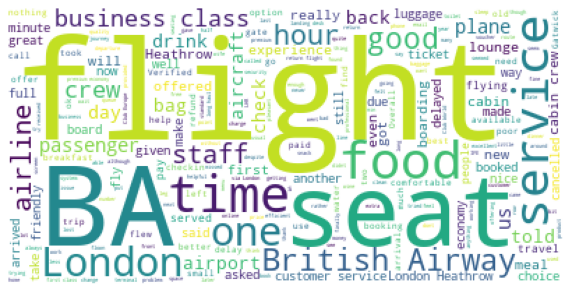

In [53]:
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

This graphic gives visual representation of keywords within the text. It displays words and phrases from small to large to demonstrate how frequently they appear within the text.

These are the main talking points in the reviews.

# Call to action

With 45.5% negative view, let's shift our focus to the negative talking points.

In [74]:
negative = ''.join(vaders[vaders['compound']<0]['reviews'])

In [78]:
wc = WordCloud(background_color='white', max_words=2000, max_font_size=99, mask= mask_logo, random_state=101, stopwords=STOPWORDS)
wc.generate(negative)

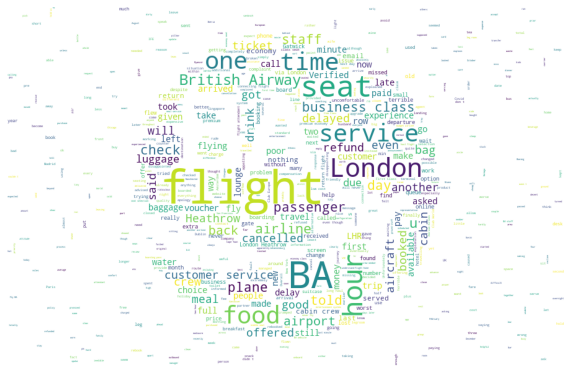

In [79]:
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

This wordcloud summarises the negative talking points, giving us starting points for improvements.

In [80]:
wc.to_file('negative_mask.png')